In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *


from BaselinePrerocess import baseline_process
from cnn import CNN

import pygad
import time

### Preprocess

In [2]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9

In [3]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = baseline_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [4]:
print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(77069, 96, 16) (9634, 96, 16) (19268, 96, 16) (77069, 96) (9634, 96) (19268, 96)


### Select event

In [5]:
start_idx = 9200
end_idx = 9600
duration = end_idx - start_idx

In [6]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(400, 96)

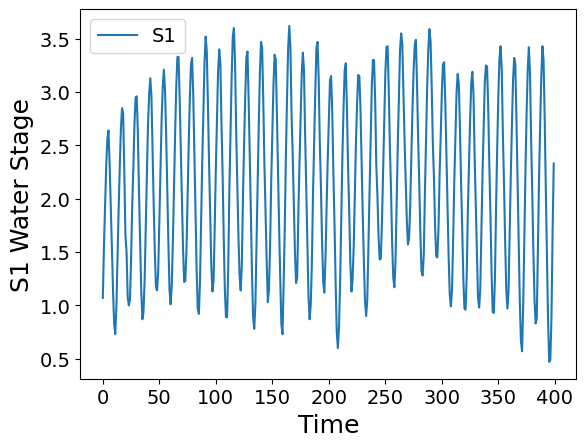

In [7]:
plt.plot(ws1[:, 0], label='S1')
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Get optimizable and not optimizable variables

In [8]:
X = test_X_mask[start_idx:end_idx, :, :]
X_1d = np.reshape(X, -1)

print(X.shape)
print(X_1d.shape)

(400, 96, 16)
(614400,)


In [9]:
gate_state = test_X_mask[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(400, 96, 7)
(268800,)


In [10]:
not_gate1 = test_X_mask[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(400, 96, 2)


In [11]:
not_gate2 = test_X_mask[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(400, 96, 7)


### GA

In [12]:
saved_model = load_model('cnn.h5', compile=False)

In [13]:
def fitness_func(ga_instance, solution, solution_idx):
    # reshape gate to 3d
    solution = np.reshape(solution, (duration, 96, 7))
    
    # get input numpy
    input_np = np.zeros(((duration, 96, 16)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    yhat = saved_model.predict(input_np, verbose=0)
    
    y_max = 0.62
    y_min = 0.2
    
    penalty_sum = 0
    for i in range (duration):
        for j in range (96):
            if (yhat[i, j] > y_max):
                penalty = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
            elif (yhat[i, j] < y_min):
                penalty = np.abs(y_min - yhat[i, j])
                
            else:
                penalty = 0
            
            penalty_sum += penalty
    
    
    if penalty_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / penalty_sum
    return fitness

In [14]:
fitness_function = fitness_func

num_generations = 200
num_parents_mating = 8

sol_per_pop = 64
num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [15]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1})

In [16]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

CPU time: 3497.8108473 seconds


In [17]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Parameters of the best solution : [0.32283879 0.55972574 0.12132432 ... 0.35254336 0.47970994 0.06427655]
Fitness value of the best solution = 9.739422768984492e-05


### Post-processing

In [18]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 16)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict(best_input)
best_perf = ws_scaler.inverse_transform(best_perf)

13/13 [==============================] - 0s 1ms/step


In [19]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

115


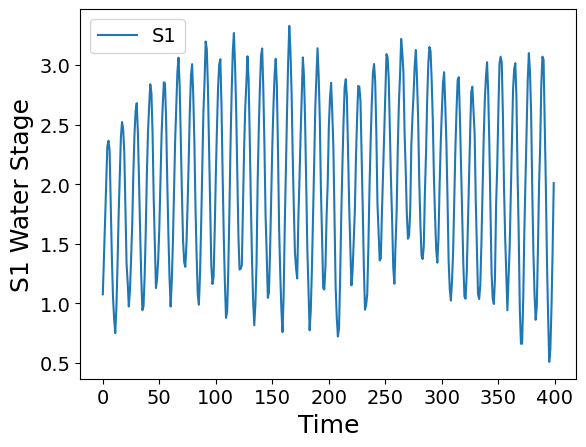

In [20]:
plt.plot(best_perf[:, 0], label='S1')
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [21]:
Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
Optimal_gate.to_csv("GA results/best_gate_event3.csv", index=False)
Optimal_gate

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.322839,0.559726,0.121324,0.186839,0.693512,0.046114,0.852428,0.039220,0.058140,0.530746,...,0.845103,0.422738,0.930453,0.471192,0.726133,0.069335,0.312155,0.336354,0.437530,0.742988
1,0.788631,0.915634,0.333854,0.703435,0.892283,0.266702,0.215031,0.260988,0.551351,0.997703,...,0.048687,0.490602,0.808757,0.658758,0.154264,0.651911,0.760220,0.867702,0.980232,0.657167
2,0.867521,0.814311,0.374496,0.813928,0.563868,0.130372,0.369775,0.376794,0.802920,0.082429,...,0.981957,0.614820,0.203098,0.953738,0.686855,0.514948,0.025330,0.546141,0.200663,0.675992
3,0.476470,0.061383,0.341357,0.600256,0.976848,0.932266,0.394098,0.695060,0.473159,0.189015,...,0.695166,0.462099,0.252452,0.886223,0.955149,0.536776,0.751746,0.657382,0.361944,0.552641
4,0.134928,0.701085,0.141203,0.516465,0.895299,0.083873,0.111104,0.174261,0.219735,0.474654,...,0.899083,0.992248,0.874592,0.863849,0.241997,0.537797,0.315807,0.398900,0.976472,0.710634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.335775,0.163528,0.672841,0.481500,0.073403,0.547777,0.401523,0.358485,0.608867,0.788175,...,0.655465,0.185843,0.608293,0.014738,0.494483,0.920044,0.993758,0.011209,0.544977,0.227005
396,0.655682,0.196948,0.785069,0.760390,0.144453,0.893886,0.498429,0.324991,0.528550,0.511518,...,0.471194,0.851963,0.921539,0.905768,0.378933,0.260423,0.765682,0.136135,0.374775,0.648554
397,0.777462,0.401327,0.172136,0.150764,0.364629,0.842322,0.987300,0.461153,0.173828,0.763218,...,0.829362,0.938660,0.109310,0.490460,0.618611,0.470527,0.513184,0.998459,0.326662,0.740471
398,0.909856,0.366733,0.196058,0.027768,0.200185,0.534213,0.125189,0.237596,0.365685,0.633164,...,0.206422,0.177365,0.315748,0.201142,0.462364,0.380557,0.636989,0.071157,0.924312,0.949034


In [22]:
Optimal_case = pd.DataFrame(best_perf)
Optimal_case.to_csv("GA results/best_performance_event3.csv", index=False)
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,1.075606,1.229037,1.371473,1.376795,1.440827,1.484762,1.673844,1.745799,1.747054,1.700690,...,1.884807,1.989733,1.342708,1.517531,1.619217,1.699473,1.137295,1.319939,1.439239,1.481250
1,1.391175,1.364479,1.545166,1.547296,1.864995,1.782232,1.990637,2.031310,2.170134,2.076805,...,1.520677,1.635208,1.099898,1.246066,1.329564,1.423468,1.086880,1.228445,1.302856,1.392150
2,1.730086,1.821613,1.878433,1.991798,2.122531,2.111090,2.232898,2.364170,2.335894,2.315880,...,1.397394,1.500967,1.113040,1.346537,1.369321,1.450939,1.273842,1.477325,1.473673,1.599500
3,2.028277,2.030562,2.140513,2.296194,2.289283,2.227957,2.415299,2.531430,2.244434,2.178750,...,1.324036,1.448001,1.312438,1.432323,1.457987,1.654240,1.623997,1.769345,1.734533,1.986033
4,2.317967,2.388703,2.471932,2.606999,2.463446,2.527727,2.634582,2.760309,2.265247,2.333557,...,1.468671,1.592912,1.720631,1.821135,1.829664,2.010512,2.079905,2.223947,2.206934,2.420849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.508721,0.592134,0.808415,0.854425,0.534900,0.642304,0.818932,0.841243,0.805620,0.880053,...,2.478081,2.655630,1.786033,1.888834,2.020690,2.120389,1.372543,1.547428,1.650258,1.744131
396,0.612724,0.652933,0.930176,0.901777,0.944194,0.920964,1.205261,1.211019,1.423748,1.365413,...,2.228212,2.421340,1.471776,1.839788,1.771141,1.870834,0.921744,1.313412,1.298841,1.311543
397,0.957744,1.007283,1.207496,1.146729,1.504736,1.487823,1.659991,1.730876,2.073412,1.995802,...,1.641580,1.647758,0.768013,1.322716,1.227252,1.124231,0.342935,0.772681,0.810063,0.626548
398,1.437220,1.395059,1.559779,1.671779,2.029545,1.949729,2.071555,2.274207,2.425955,2.391211,...,1.253244,1.225583,0.473350,0.867964,0.891935,0.820892,0.307983,0.505535,0.673972,0.587326
